In [50]:
import numpy as np
from sklearn.decomposition import PCA 
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
from lifelines import CoxPHFitter, KaplanMeierFitter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.metrics import brier_score_loss
import datetime
import joblib

In [2]:
Tumor_file = pd.read_excel('dataset.xlsx')
dataset = Tumor_file.values

In [55]:
d1 = Tumor_file["置管方式"].values.copy()
d1-=1
tmp1 = Tumor_file["肺部放疗"].values.copy()
tmp2 = Tumor_file["纵隔放疗"].values.copy()
d2 = Tumor_file["胸部治疗"].values.copy()
for i in range(len(tmp2)):
    if tmp2[i] == 1 or tmp1[i] == 1:
        d2[i] = 1

tmp3 = Tumor_file["卵巢癌"].values.copy()
d3  = Tumor_file["宫颈癌"].values.copy()
for i in range(len(tmp3)):
    if tmp3[i] == 1:
        d3[i] = 1

tmp4 = Tumor_file["L肾癌"].values.copy()
tmp5 = Tumor_file["O肾上腺癌"].values.copy()
tmp6 = Tumor_file["M输尿管膀胱"].values.copy()
d4 = Tumor_file["K睾丸癌"].values.copy()
for i in range(len(tmp4)):
    if tmp4[i] == 1 or tmp5[i] == 1 or tmp6[i] == 1:
        d4[i] = 1
d5 = Tumor_file["性别"].values.copy()
d5 -= 1
        

data = np.vstack((
    Tumor_file["粒细胞/淋巴细胞"].values.copy(),
    Tumor_file["D二聚体"].values.copy(),
    Tumor_file["化疗"].values.copy(),
    d1,
    d2,
    Tumor_file["本院治疗年龄"].values.copy(),
    Tumor_file["血小板"].values.copy(),
    Tumor_file["血红蛋白"].values.copy(),
    Tumor_file["BMI"].values.copy(),
    # d5
    # Tumor_file["既往置管史"].values.copy(),
    # Tumor_file["既往血栓史"].values.copy(),
    # Tumor_file["肺癌"].values.copy(),
    # Tumor_file["胃癌"].values.copy(),
    # Tumor_file["淋巴瘤"].values.copy(),
    # d3,
    # d4
    )).T
variable_names = [
    "粒细胞/淋巴细胞",
    "D二聚体",
    "化疗",
    "置管方式",
    "胸部治疗",
    "本院治疗年龄",
    "血小板",
    "血红蛋白",
    "BMI",
    # "性别",
    # "既往置管史",
    # "既往血栓史",
    # "肺癌",
    # "胃癌",
    # "淋巴瘤",
    # "妇科肿瘤",
    # "泌尿系统肿瘤"
    ]
tumor = Tumor_file["血栓有1；无0"].values.copy()

dst = Tumor_file["置管日期"].values.copy()
ded = Tumor_file["拔管日期"].values.copy()
during = Tumor_file["血栓发生置管后天数"].values.copy()

for i in range(data.shape[0]):
    if type(dst[i]).__name__ == 'str':
        dst[i] = pd.to_datetime(dst[i])
    if type(ded[i]).__name__ == 'str':
        ded[i] = pd.to_datetime(ded[i])
endtme = pd.to_datetime('2022-06-01')
print(data.shape)
print(endtme)

(20667, 9)
2022-06-01 00:00:00


In [53]:
have_built = 0
Tumor = []
Time = []
for i in range(data.shape[0]):
    flag = True
    for j in range(data.shape[1]):
        if (type(data[i,j]).__name__ != 'float' and type(data[i,j]).__name__ != 'int') or np.isnan(data[i,j]) or data[i,j]<0:
            flag = False
            break
    if np.isnan(tumor[i]):
        flag = False
    if data[i,3] >= 2:
        flag = False
    if flag:
        if tumor[i] == 0:
            Time.append((ded[i]-dst[i]).days)
        else:
            Time.append(during[i])
        if have_built == 0:
            Data = data[i]
            Data = np.reshape(Data,(1,-1))
        else:
            Data = np.vstack((Data,np.reshape(data[i],(1,-1))))
        Tumor.append(tumor[i])
        have_built += 1
print(have_built)


10512


In [12]:
for i in range(Data.shape[0]):
    Data[i][0] = 0 if Data[i][0] < 3.0 else 1
    Data[i][1] = 0 if Data[i][1] < 1.03 else 1
    Data[i][6] = 0 if Data[i][6] < 350 else 1
    Data[i][7] = 0 if Data[i][7] < 100 else 1
    Data[i][8] = 0 if Data[i][8] < 27 else 1
print(Data[0])

[0 0 1 0 0.0 61 0 1 0 2 0 0 0 0]


In [6]:
print(np.mean(Time))

60.580479452054796


In [56]:
#数据处理
dataframe = pd.DataFrame({'time':Time,'event':Tumor})
for i in range(Data.shape[1]):
    dataframe[variable_names[i]] = Data[:,i]
print(dataframe)

       time  event  粒细胞/淋巴细胞  D二聚体 化疗 置管方式 胸部治疗 本院治疗年龄    血小板   血红蛋白  \
0         2      1  1.769231   0.1  1    0  0.0     61  141.0  112.0   
1        64      0   1.22449  1.36  1    1  0.0     57  281.0  115.0   
2        16      1  2.732673   0.1  1    1  0.0     30  267.0  108.0   
3        50      0  2.939086  0.96  1    1  0.0     51  276.0  114.0   
4       101      0  1.172589  3.57  1    1  0.0     52  303.0  121.0   
...     ...    ...       ...   ... ..  ...  ...    ...    ...    ...   
10507    35      0  1.864407  0.14  0    1  0.0     27  292.0  119.0   
10508    30      0  4.288462   0.1  0    1  0.0     62  401.0  110.0   
10509    15      0  5.367647   0.6  0    0  0.0     50  640.0   74.0   
10510    15      0  1.294872   1.3  0    1  0.0     64  138.0  122.0   
10511    15      1     11.65  0.53  0    0  0.0     70  169.0  131.0   

             BMI  
0      22.313278  
1      23.805402  
2      26.037494  
3      22.038567  
4      20.811655  
...          ...  
10

# Kaplan-Meier方法

(10512, 11)


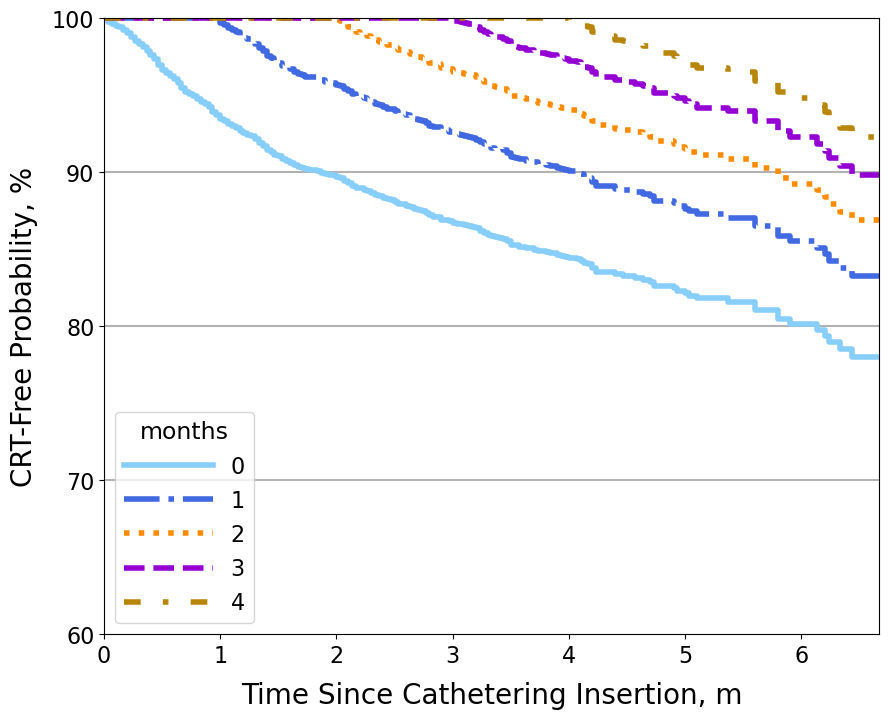

In [39]:
#画图
df_1 = dataframe[dataframe['time']>=30]
df_2 = dataframe[dataframe['time']>=60]
df_3 = dataframe[dataframe['time']>=90]
df_4 = dataframe[dataframe['time']>=120]

print(dataframe.shape)

kmf = KaplanMeierFitter(label='0')
kmf_1 = KaplanMeierFitter(label='1')
kmf_2 = KaplanMeierFitter(label='2')
kmf_3 = KaplanMeierFitter(label='3')
kmf_4 = KaplanMeierFitter(label='4')

kmf.fit(dataframe.time,dataframe.event)
kmf_1.fit(df_1.time,df_1.event)
kmf_2.fit(df_2.time,df_2.event)
kmf_3.fit(df_3.time,df_3.event)
kmf_4.fit(df_4.time,df_4.event)

plt1,ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0,200)
ax.set_ylim(0.6,1)
ax.set_xticks(range(0,200,30))
ax.set_xticklabels(['0','1','2','3','4','5','6'],fontsize=16)
ax.set_yticks(np.arange(0.6,1.01,0.1))
ax.set_yticklabels(['60','70','80','90','100'],fontsize=16)

ax.axhline(y=0.9, color='black', alpha=0.3)
ax.axhline(y=0.8, color='black', alpha=0.3)
ax.axhline(y=0.7, color='black', alpha=0.3)
# ax.axhline(y=0.6, color='black', alpha=0.3)

kmf.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='lightskyblue',linewidth=4)
kmf_1.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='royalblue',linewidth=4,linestyle='-.')
kmf_2.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkorange',linewidth=4,linestyle=':')
kmf_3.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkviolet',linewidth=4,linestyle='--')
kmf_4.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkgoldenrod',linewidth=4,linestyle=(0, (3, 4, 1, 4, 3, 4)))
legend = ax.legend(loc='lower left',prop={'size': 16},title='months',title_fontsize=17,handlelength=4)
ax.set_ylabel('CRT-Free Probability, %',fontsize=20,labelpad=10)
ax.set_xlabel('Time Since Cathetering Insertion, m',fontsize=20,labelpad=10)
plt.show()

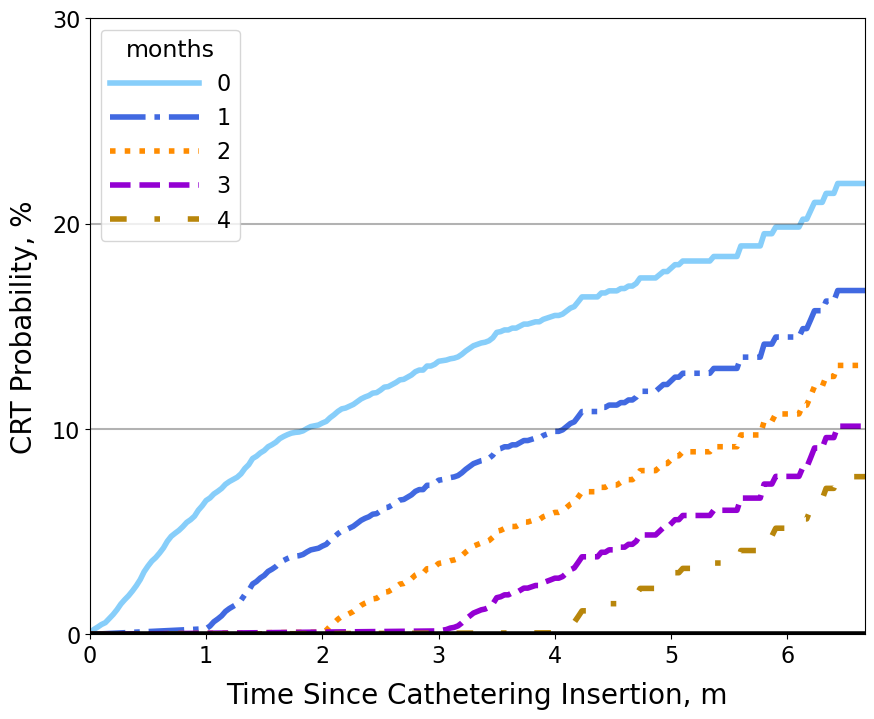

In [21]:
plt1,ax = plt.subplots(figsize=(10,8))

kmf_anti = 1-kmf.survival_function_
kmf1_anti = 1-kmf_1.survival_function_
kmf2_anti = 1-kmf_2.survival_function_
kmf3_anti = 1-kmf_3.survival_function_
kmf4_anti = 1-kmf_4.survival_function_
ax.plot(kmf_anti.index,kmf_anti.values, color='lightskyblue',linewidth=4,label='0')
ax.plot(kmf1_anti.index,kmf1_anti.values, color='royalblue',linewidth=4,linestyle='-.',label='1')
ax.plot(kmf2_anti.index,kmf2_anti.values, color='darkorange',linewidth=4,linestyle=':',label='2')
ax.plot(kmf3_anti.index,kmf3_anti.values, color='darkviolet',linewidth=4,linestyle='--',label='3')
ax.plot(kmf4_anti.index,kmf4_anti.values, color='darkgoldenrod',linewidth=4,linestyle=(0, (3, 5, 1, 5, 3, 5)),label='4')

ax.axhline(y=0, color='black', alpha=1,linewidth=4)
ax.axhline(y=0.1, color='black', alpha=0.3)
ax.axhline(y=0.2, color='black', alpha=0.3)
ax.axhline(y=0.3, color='black', alpha=0.3)
ax.axhline(y=0.4, color='black', alpha=0.3)

legend = ax.legend(loc='upper left',prop={'size': 16},title='months',title_fontsize=17,handlelength=4)
ax.set_xlim(0,200)
ax.set_ylim(0,0.3)
ax.set_xticks(range(0,200,30))
ax.set_xticklabels(['0','1','2','3','4','5','6'],fontsize=16)
ax.set_yticks(np.arange(0.0,0.31,0.1))
ax.set_yticklabels(['0','10','20','30'],fontsize=16)

ax.set_ylabel('CRT Probability, %',fontsize=20,labelpad=10)
ax.set_xlabel('Time Since Cathetering Insertion, m',fontsize=20,labelpad=10)
plt.show()

In [167]:
print(plt.rcParams['font.family'])

['sans-serif']


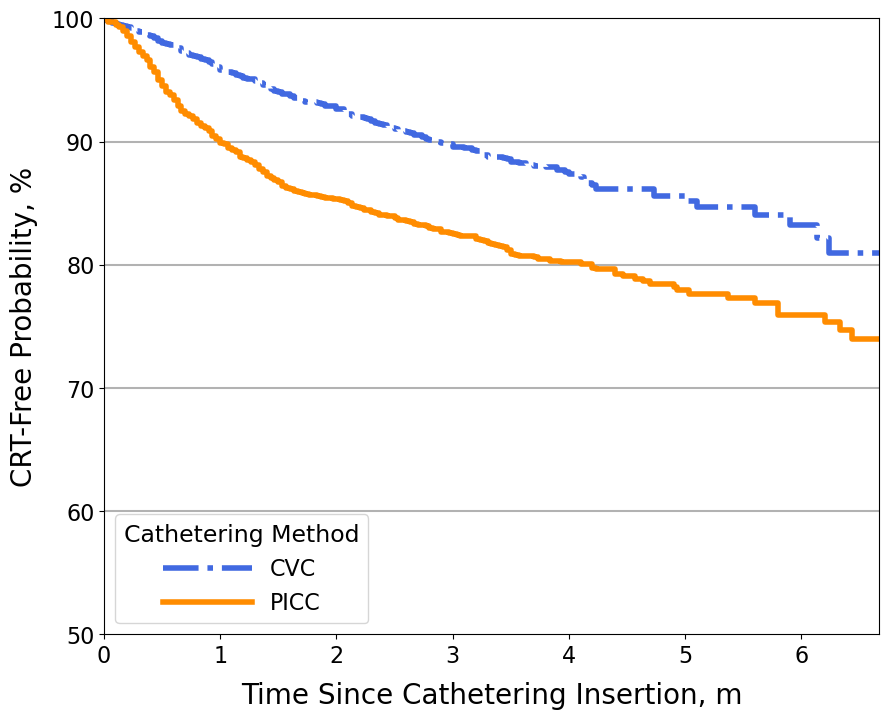

In [22]:
df_cvc = dataframe[dataframe['Variable4'] == 0]
df_picc = dataframe[dataframe['Variable4'] == 1]

plt1,ax = plt.subplots(figsize=(10,8))
kmf_cvc = KaplanMeierFitter(label='CVC')
kmf_picc = KaplanMeierFitter(label='PICC')

kmf_cvc.fit(df_cvc.time,df_cvc.event)
kmf_picc.fit(df_picc.time,df_picc.event)

ax.set_xlim(0,200)
ax.set_ylim(0.5,1)
ax.set_xticks(range(0,200,30))
ax.set_xticklabels(['0','1','2','3','4','5','6'],fontsize=16)
ax.set_yticks(np.arange(0.5,1.01,0.1))
ax.set_yticklabels(['50','60','70','80','90','100'],fontsize=16)

ax.axhline(y=0.9, color='black', alpha=0.3)
ax.axhline(y=0.8, color='black', alpha=0.3)
ax.axhline(y=0.7, color='black', alpha=0.3)
ax.axhline(y=0.6, color='black', alpha=0.3)

kmf_cvc.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='royalblue',linewidth=4,linestyle='-.')
kmf_picc.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkorange',linewidth=4)
legend = ax.legend(loc='lower left',prop={'size': 16},title='Cathetering Method',title_fontsize=17,handlelength=4)
ax.set_ylabel('CRT-Free Probability, %',fontsize=20,labelpad=10)
ax.set_xlabel('Time Since Cathetering Insertion, m',fontsize=20,labelpad=10)
plt.show()

# Cox风险回归模型

In [57]:
#Cox风险回归模型
train_set,test_set = train_test_split(dataframe,test_size=0.2,random_state=42)
cph = CoxPHFitter(penalizer=0.005)
cph.fit(train_set,duration_col='time',event_col='event')
cph.print_summary()
# cph.check_assumptions(train_set,p_value_threshold=0.05,show_plots=True)

<lifelines.CoxPHFitter: fitted with 8409 total observations, 7592 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.005
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 8409
number of events observed = 817
   partial log-likelihood = -6759.13
         time fit was run = 2024-05-20 02:21:20 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
粒细胞/淋巴细胞   0.01      1.01      0.01           -0.00            0.02                1.00                1.02
D二聚体       0.01      1.01      0.01           -0.01            0.03                0.99                1.03
化疗         0.27      1.31      0.11            0.05            0.49                1.05                1.63
置管方式       0.49      1.64      0.07            0.35            0.63                1.42                1.88
胸部治疗       0.82      2.28      0.11            0.61            1.03                1.85                2.81
本院治疗年龄     0.02      1.02      0.00            0.02            0.03                1.02                1.03
血小板       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
血红蛋白       0.01      1.01      0.00            0.00            0.01                1.00                1.01
BMI       -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99

           cmp to     z      p  -log2(p)
covariate                               
粒细胞/淋巴细胞     0.00  1.18   0.24      2.06
D二聚体         0.00  1.22   0.22      2.17
化疗           0.00  2.37   0.02      5.83
置管方式         0.00  6.86 <0.005     37.06
胸部治疗         0.00  7.71 <0.005     46.13
本院治疗年龄       0.00  7.77 <0.005     46.83
血小板          0.00 -0.67   0.50      0.99
血红蛋白         0.00  3.40 <0.005     10.53
BMI          0.00 -3.01 <0.005      8.57
---
Concordance = 0.66
Partial AIC = 13536.26
log-likelihood ratio test = 249.13 on 9 df
-log2(p) of ll-ratio test = 158.84

In [54]:
print(dataframe['event'])

0        1
1        0
2        1
3        0
4        0
        ..
10507    0
10508    0
10509    0
10510    0
10511    1
Name: event, Length: 10512, dtype: int64


In [11]:
import joblib
joblib.dump(cph,'cph.pkl')

['cph.pkl']

In [7]:
# prediction_probs = cph.predict_cumulative_hazard(test_set).T
prediction_probs = cph.predict_survival_function(test_set).T
# corr_prediction_probs = prediction_probs.apply(lambda c: (c/c.loc[dataframe.loc[c.name,'time']]).clip(upper=1),axis=1)
# prediction_probs = 1-prediction_probs
# corr_prediction_probs = 1-corr_prediction_probs
print(prediction_probs.shape)

(2103, 273)


In [8]:
print(prediction_probs.shape)
# prediction_probs.iloc[k].plot(ls="--")
# corr_prediction_probs.iloc[k].plot()
health_sum = []
tumor_sum = []
num_month = 10
for i in range(num_month):
    health_sum.append([])
    tumor_sum.append([])
for k in range(prediction_probs.shape[0]):
    # print(dataframe.loc[prediction_probs.iloc[k].name,'event'],prediction_probs.iloc[k,-1],corr_prediction_probs.iloc[k,-1])
    for i in range(num_month):
        if dataframe.loc[prediction_probs.iloc[k].name,'event'] == 1:
            tumor_sum[i].append(prediction_probs.iloc[k,30*i])
        else :
            health_sum[i].append(prediction_probs.iloc[k,30*i])
for i in range(num_month):
    print('{} days predicted_probability  Tumor:{:.2f}%   Health:{:.2f}%'.format(i*30,np.mean(tumor_sum[i])*100,np.mean(health_sum[i])*100))

(2103, 273)
0 days predicted_probability  Tumor:99.89%   Health:99.92%
30 days predicted_probability  Tumor:91.32%   Health:93.70%
60 days predicted_probability  Tumor:86.09%   Health:89.79%
90 days predicted_probability  Tumor:81.70%   Health:86.43%
120 days predicted_probability  Tumor:78.27%   Health:83.77%
150 days predicted_probability  Tumor:76.05%   Health:82.02%
180 days predicted_probability  Tumor:74.17%   Health:80.53%
210 days predicted_probability  Tumor:71.37%   Health:78.27%
240 days predicted_probability  Tumor:69.48%   Health:76.73%
270 days predicted_probability  Tumor:69.48%   Health:76.73%


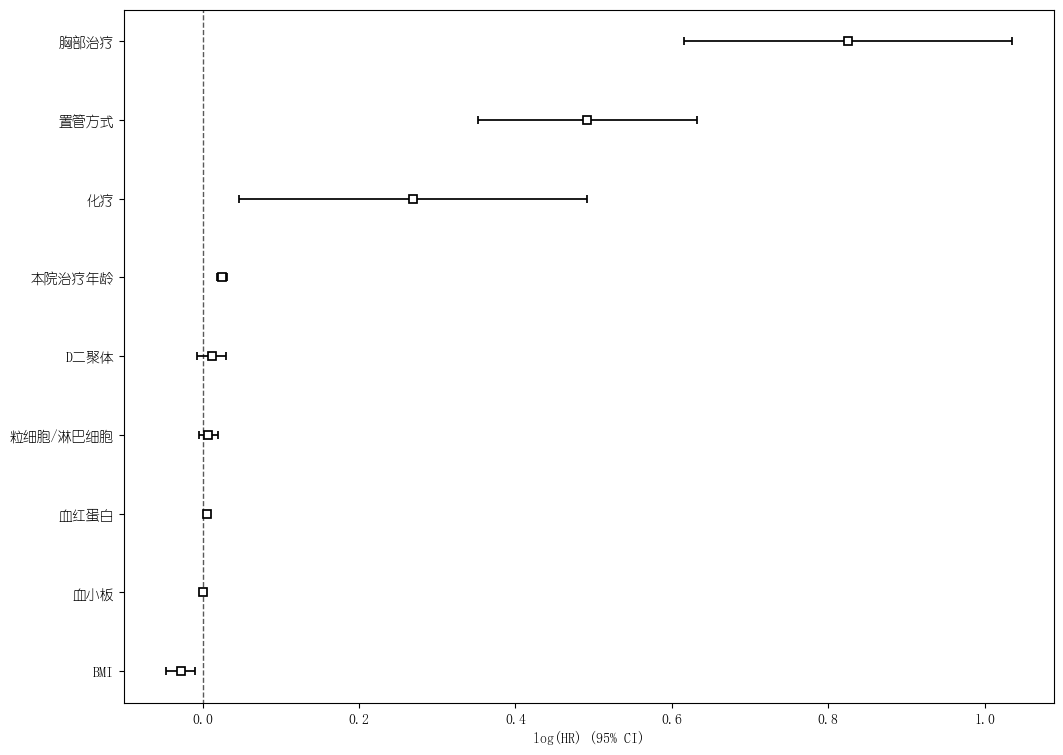

In [19]:
matplotlib.rc("font",family="YouYuan")
fig,ax = plt.subplots(figsize=(12,9))
cph.plot(ax=ax)
plt.show()

In [10]:
certain_prob = cph.predict_survival_function(test_set)
print(certain_prob.index)

Index([  0.0,   1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,   9.0,
       ...
       357.0, 358.0, 360.0, 365.0, 367.0, 374.0, 392.0, 397.0, 408.0, 464.0],
      dtype='float64', length=273)


In [102]:
from lifelines.utils import concordance_index
concordance_index(test_set['time'],-cph.predict_partial_hazard(test_set),test_set['event'])

0.6689266776662578

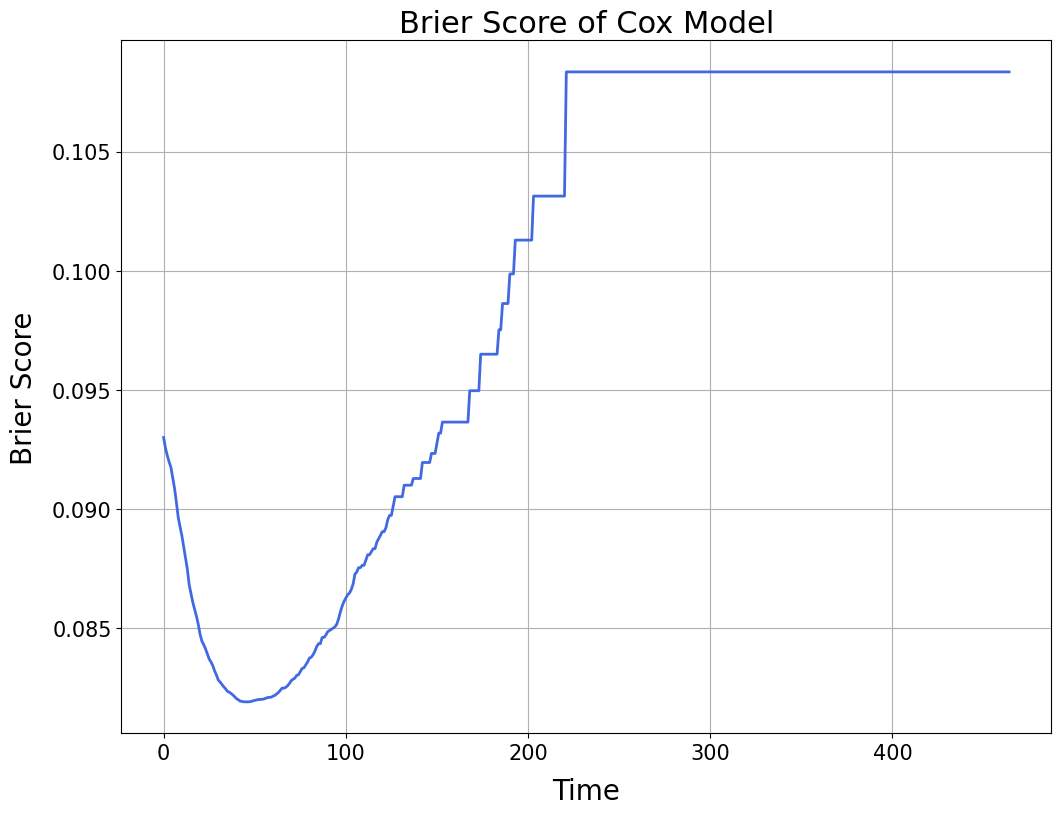

In [24]:
loss_dict = {}
for i in certain_prob.index:
    brier_score = brier_score_loss(test_set['event'],1-np.array(certain_prob.loc[i]),pos_label=1)
    loss_dict[i] = [brier_score]

plt.rc('font',family='sans-serif')
loss_df = pd.DataFrame(loss_dict).T
fig,ax = plt.subplots(figsize=(12,9))
ax.plot(loss_df.index,loss_df,linewidth=2,color='royalblue')
ax.set_xlabel('Time',fontsize=20,labelpad=10)
ax.set_ylabel('Brier Score',fontsize=20,labelpad=10)
ax.set_title('Brier Score of Cox Model',fontsize=22)
ax.tick_params(axis='both',labelsize=15)
ax.grid()
    

# 随机生存森林

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sksurv.datasets import get_x_y

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import ExtraSurvivalTrees

In [13]:
tmp = [(Tumor[i],Time[i]) for i in range(len(Tumor))]
tmp = np.array(tmp,dtype=[('event',bool),('time',float)])
print(tmp)

[( True,  2.) (False, 64.) ( True, 16.) ... (False, 15.) (False, 15.)
 ( True, 15.)]


In [58]:
# data_x,data_y = get_x_y(dataframe,attr_labels=['event','time'],pos_label=1,survival=True)
X_train,y_train = get_x_y(train_set,attr_labels=['event','time'],pos_label=1,survival=True)
X_test,y_test = get_x_y(test_set,attr_labels=['event','time'],pos_label=1,survival=True)
# X_train,X_test,y_train,y_test = train_test_split(data_x,data_y,test_size=0.2,random_state=42)

In [90]:
# gbc = GradientBoostingSurvivalAnalysis(n_estimators=100,learning_rate=0.01,max_depth=3)
# gbc.fit(X_train,y_train)
# gbc.score(X_test,y_test)

0.6416781828444634

In [59]:
rsf = RandomSurvivalForest(
    n_estimators=150,max_depth=5,min_samples_split=27, min_samples_leaf=14, n_jobs=-1, random_state=42
)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)

0.6510033672655079

In [60]:
joblib.dump(rsf,'rsf.pkl')

['rsf.pkl']

In [61]:
rsf_mdl = joblib.load('rsf.pkl')
print(rsf_mdl.unique_times_)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [57]:
# est = ExtraSurvivalTrees(n_estimators=1000,max_depth=7,min_samples_split=20, min_samples_leaf=10, random_state=42)
# est.fit(X_train, y_train)
# est.score(X_test, y_test)

0.6562197092084007

[[  4.0875       0.26         1.           1.           0.
   68.         245.         143.          21.23057202]]
(1, 274)


d:\Anaconda3\envs\Tumor\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


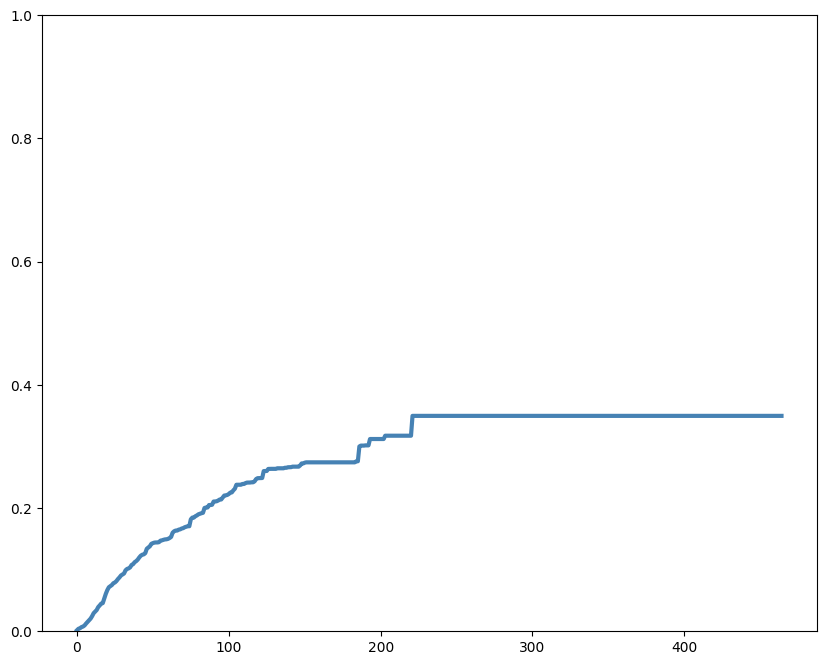

In [62]:
samp = X_test.iloc[5,:]
samp = list(samp.values)
samp = np.reshape(samp,(1,-1))

print(samp)
rsf_prob = rsf.predict_cumulative_hazard_function(samp,return_array=True)
# print(rsf.unique_times_)
print(rsf_prob.shape)

result = {}
result['time'] = rsf.unique_times_.tolist()
result['prob'] = rsf_prob[0].tolist()

plt1,ax = plt.subplots(figsize=(10,8))

ax.set_ylim(0,1)

ax.plot(rsf.unique_times_,rsf_prob[0],color='steelblue',linewidth=3)

In [71]:
import json
inputX = np.array(list((item.__dict__).values()))
inputX = np.reshape(inputX,(1,-1))
probs = np.zeros((inputX.shape[0],len(base_mdl)))
for i,(name,m) in enumerate(base_mdl.items()):
    probs[:,i] = m.predict_proba(inputX)[:,1]
meta_p = probs.mean(axis=1)[0]
result = {}
result['time'] = rsf.unique_times_.tolist()
result['sequential_prob'] = rsf_prob[0].tolist()
result['probability']=meta_p
return result

{'time': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 1

In [77]:
result={}
result['time'] = rsf.unique_times_.tolist()
result['sequential_prob'] = rsf_prob[0].tolist()
print(result)

{'time': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 1

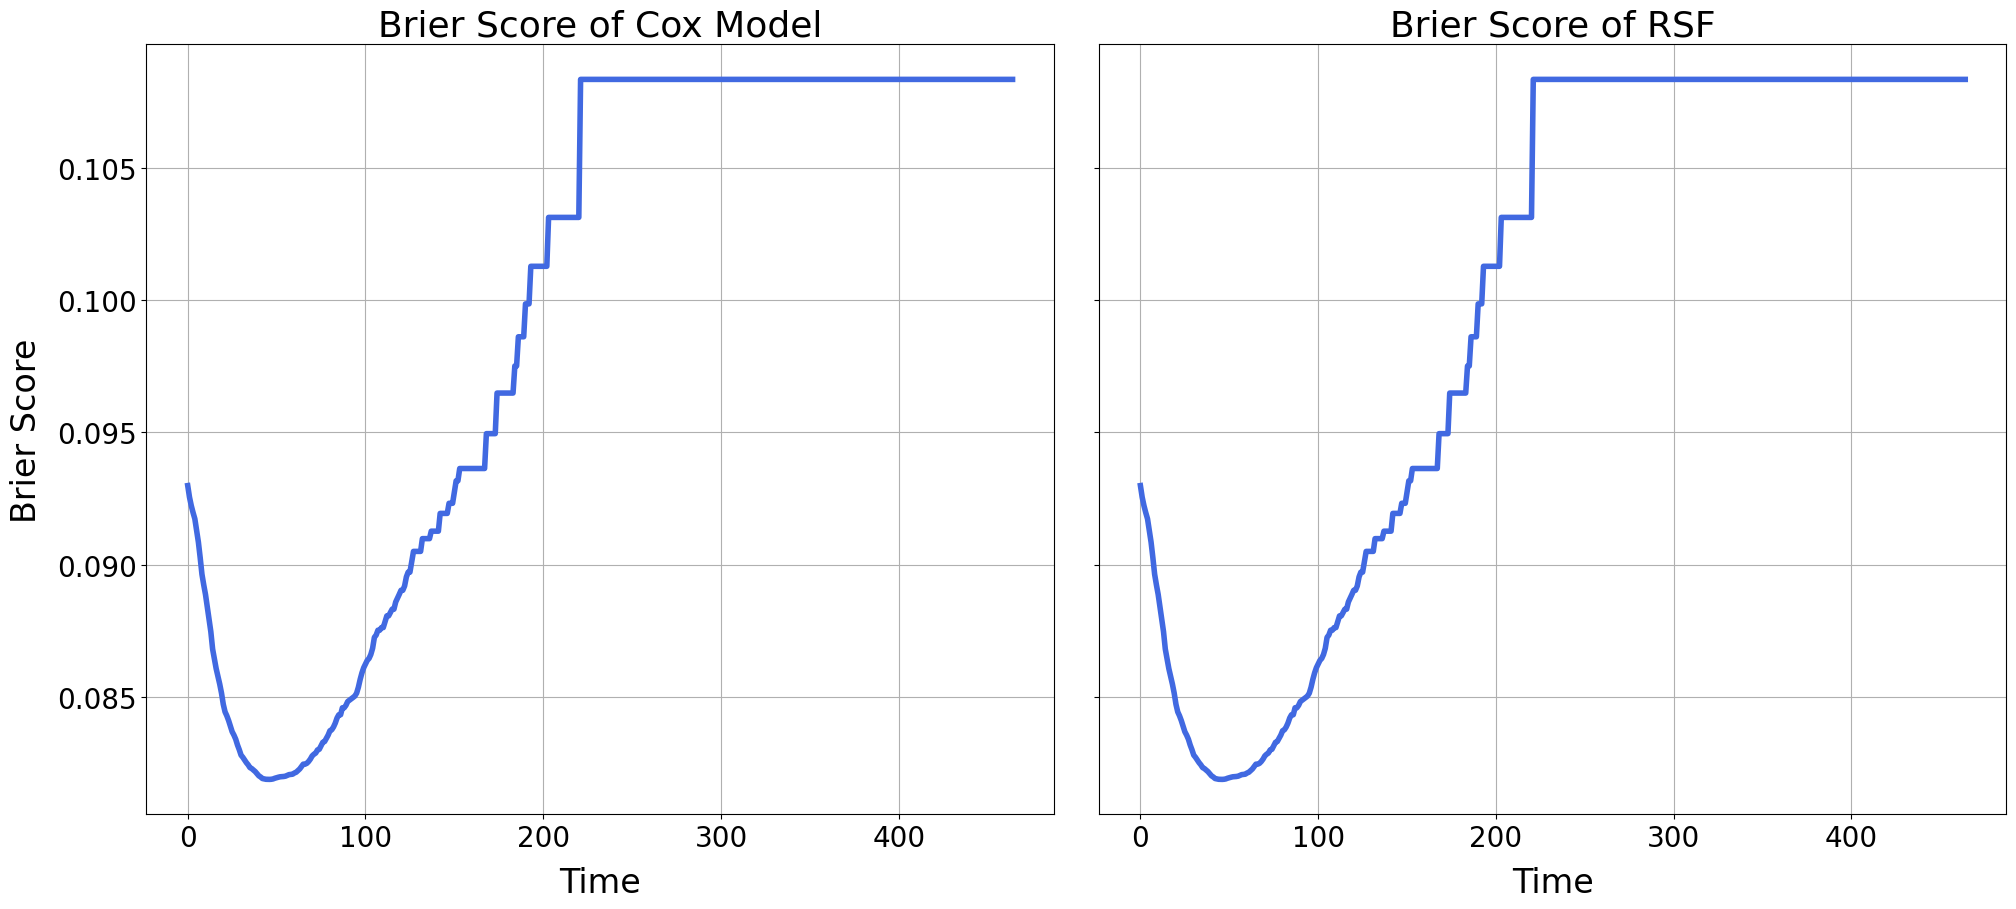

In [43]:
loss_dict_rsf = {}
loss_dict_cox = {}

time_points = certain_prob.index
for i in range(rsf_prob.shape[1]):
    brier_score = brier_score_loss(test_set['event'],1-rsf_prob[:,i],pos_label=1)
    loss_dict_rsf[time_points[i]] = [brier_score]

for i in certain_prob.index:
    brier_score = brier_score_loss(test_set['event'],1-np.array(certain_prob.loc[i]),pos_label=1)
    loss_dict_cox[i] = [brier_score]

plt.rc('font',family='sans-serif')

loss_df_rsf = pd.DataFrame(loss_dict_rsf).T
loss_df_cox = pd.DataFrame(loss_dict_cox).T
fig,ax = plt.subplots(1,2,figsize=(24,10),sharey=True)
fig.subplots_adjust(wspace=0.05)

ax[0].plot(loss_df_cox.index,loss_df_cox,linewidth=4,color='royalblue')
ax[0].set_xlabel('Time',fontsize=24,labelpad=10)
ax[0].set_ylabel('Brier Score',fontsize=24,labelpad=10)
ax[0].set_title('Brier Score of Cox Model',fontsize=26)
ax[0].tick_params(axis='both',labelsize=20)
ax[0].grid()

ax[1].plot(loss_df_cox.index,loss_df_cox,linewidth=4,color='royalblue')
ax[1].set_xlabel('Time',fontsize=24,labelpad=10)
ax[1].set_title('Brier Score of RSF',fontsize=26)
ax[1].tick_params(axis='both',labelsize=20)
ax[1].grid()

# 新数据实例研究

In [40]:
new_file = pd.read_excel("new_dataset.xlsx")
new_dataset = new_file.values

In [92]:
#0 cvc, 1 picc
cathterization = new_file["置管类型"].values.copy()
cathterization-=1

chemical = new_file["化疗周期"].values.copy()
for i in range(len(chemical)):
    if chemical[i] > 0:
        chemical[i] = 1

# tmp1 = new_file["肺部放疗"].values.copy()
# tmp2 = new_file["纵隔放疗"].values.copy()
# chest = new_file["胸部治疗"].values.copy()
# for i in range(len(tmp2)):
#     if tmp2[i] == 1 or tmp1[i] == 1:
#         chest[i] = 1

wgts = new_file["体重（Kg）"].values.copy()
hgt = new_file["身高（m）"].values.copy()
BMIs = []
for i in range(len(wgts)):
    if hgt[i] == 0:
        BMIs.append(0)
    else:
        BMIs.append(wgts[i]/(hgt[i]*hgt[i]))
BMIs = np.array(BMIs)

genders = new_file["性别\n（1男 3女）"].values.copy()
genders-=1

new_data = np.vstack((
    #new_file["粒细胞/淋巴细胞"].values.copy(),
    new_file[" D-二聚体"].values.copy(),
    chemical,
    cathterization,
    #chest,
    new_file["年龄（岁） "].values.copy(),
    new_file["血小板"].values.copy(),
    new_file["血红蛋白"].values.copy(),
    BMIs,
    genders
    # d5,
    # Tumor_file["既往置管史"].values.copy(),
    # Tumor_file["既往血栓史"].values.copy(),
    # Tumor_file["肺癌"].values.copy(),
    # Tumor_file["胃癌"].values.copy(),
    # Tumor_file["淋巴瘤"].values.copy(),
    # d3,
    # d4
    )).T
variable_names = [
    # "粒细胞/淋巴细胞",
    "D二聚体",
    "化疗",
    "置管方式",
    # "胸部治疗",
    "本院治疗年龄",
    "血小板",
    "血红蛋白",
    "BMI",
    "性别",
    # "既往置管史",
    # "既往血栓史",
    # "肺癌",
    # "胃癌",
    # "淋巴瘤",
    # "妇科肿瘤",
    # "泌尿系统肿瘤"
    ]

tumor = new_file["静脉血栓0.未查1.有  2.无"].values.copy()

nnew_dst = new_file["置管日期"].values.copy()
new_ded = new_file[" 拔管日期"].values.copy()
new_during = new_file["发生时间"].values.copy()
new_dst = []
for i in range(new_data.shape[0]):
    if type(nnew_dst[i]).__name__ == 'datetime64':
        datestr = str(nnew_dst[i]).split('T')[0]
        new_dst.append(datetime.datetime.strptime(datestr,'%Y-%m-%d'))
        print(new_dst[i])

print(new_data.shape)

2023-10-26 00:00:00
2022-08-04 00:00:00
2023-08-09 00:00:00
2023-07-31 00:00:00
2023-09-07 00:00:00
2022-06-24 00:00:00
2022-11-09 00:00:00
2022-03-12 00:00:00
2022-06-25 00:00:00
2022-03-17 00:00:00
2023-04-07 00:00:00
2022-06-28 00:00:00
2022-01-27 00:00:00
2022-06-08 00:00:00
2023-01-11 00:00:00
2023-08-31 00:00:00
2023-02-09 00:00:00
2023-01-12 00:00:00
2022-09-17 00:00:00
2022-10-10 00:00:00
2022-12-21 00:00:00
2023-01-11 00:00:00
2022-12-30 00:00:00
2023-09-19 00:00:00
2023-10-10 00:00:00
2023-10-31 00:00:00
2022-05-27 00:00:00
2022-11-03 00:00:00
2022-12-29 00:00:00
2023-03-21 00:00:00
2023-07-27 00:00:00
2023-09-15 00:00:00
2023-04-13 00:00:00
2023-09-19 00:00:00
2023-08-31 00:00:00
2023-09-20 00:00:00
2023-05-18 00:00:00
2023-10-19 00:00:00
2022-10-17 00:00:00
2023-04-20 00:00:00
2022-03-10 00:00:00
2022-04-06 00:00:00
2023-06-02 00:00:00
2023-06-25 00:00:00
2023-07-18 00:00:00
2023-08-10 00:00:00
2023-09-08 00:00:00
2022-01-11 00:00:00
2022-06-02 00:00:00
2022-06-23 00:00:00


In [88]:
print(set(tumor))

{0.0, 1.0, 2.0, 3.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [78]:
print(new_dst[1],type(new_dst[1]))
# print(new_ded[1],type(new_ded[1]))

2022-08-04 00:00:00 <class 'datetime.datetime'>


In [91]:
have_built = 0
new_Tumor = []
new_Time = []
for i in range(new_data.shape[0]):
    # print(i,new_data[i])
    flag = True
    for j in range(new_data.shape[1]):
        if np.isnan(new_data[i,j]) or new_data[i,j]<0:
            # print("first ",i,j,new_data[i,j])
            flag = False
            break
    if np.isnan(tumor[i]) or tumor[i] == 0 or tumor[i] == 3:
        # print("second ",i,tumor[i])
        flag = False
    #检查一下置管方式是不是1或2，注意置管方式在data中是第几个
    if new_data[i,2] >= 2:
        # print("third ",i,new_data[i,2])
        flag = False
    if tumor[i] == 1 and np.isnan(new_during[i]):
        flag = False
    if flag:
        if tumor[i] == 2:
            # print(i,(new_ded[i]-new_dst[i]).days)
            new_Time.append((new_ded[i]-new_dst[i]).days)
        else:
            # print(i,new_during[i],tumor[i],np.isnan(new_during[i]))
            new_Time.append(new_during[i]/24/30)
        if have_built == 0:
            new_Data = new_data[i]
            new_Data = np.reshape(new_Data,(1,-1))
        else:
            new_Data = np.vstack((new_Data,np.reshape(new_data[i],(1,-1))))
        new_Tumor.append(tumor[i]%2)
        have_built += 1
print(have_built)

1684


In [111]:
print(new_Tumor.count(1))

180


In [112]:
#数据处理
new_dataframe = pd.DataFrame({'time':new_Time,'event':new_Tumor})
for i in range(new_Data.shape[1]):
    new_dataframe[variable_names[i]] = new_Data[:,i]
print()

X_test,y_test = get_x_y(new_dataframe,attr_labels=['event','time'],pos_label=1,survival=True)

       time  event  D二聚体   化疗  置管方式  本院治疗年龄    血小板   血红蛋白        BMI   性别
0      36.0    0.0  0.44  1.0   1.0    29.0  211.0  112.0  19.444444  0.0
1     100.0    0.0  0.19  1.0   0.0    30.0  128.0  129.0  24.088223  1.0
2     123.0    0.0  1.02  1.0   0.0    68.0  177.0  131.0  27.053803  1.0
3      64.0    0.0  5.53  1.0   0.0    69.0  291.0  127.0  27.548209  1.0
4      31.0    0.0  3.41  1.0   0.0    69.0  179.0  130.0  24.977043  1.0
...     ...    ...   ...  ...   ...     ...    ...    ...        ...  ...
1679    6.0    0.0  1.62  1.0   0.0    57.0  424.0  108.0  17.301038  0.0
1680    9.0    0.0  0.19  1.0   0.0    71.0  352.0  135.0  26.989619  0.0
1681   31.0    0.0  0.20  1.0   1.0    71.0  337.0  133.0  26.643599  0.0
1682   11.0    0.0  3.20  0.0   0.0    54.0   31.0  106.0  24.419279  0.0
1683   81.0    0.0  0.37  1.0   1.0    60.0  275.0  158.0  26.892323  0.0

[1684 rows x 10 columns]


In [110]:
concordance_index(new_dataframe['time'],-cph.predict_partial_hazard(new_dataframe),new_dataframe['event'])

0.5462310195227765

In [109]:
rsf.score(X_test, y_test)

0.5508947939262473